very rudimentary algorithm to clean up the inference
* Filtering out uuids
* splitting inferences based on '_' and '-'
* filtering anything one worded(very unlikely that any inference would be single word)

In [33]:
import json
import uuid
import pandas as pd
import re

In [34]:
# filepath = "Inferences.json"
filepath = "inferences-anant.json"
with open(filepath, "r", encoding="utf-8") as file:
    inferences = json.load(file)["inferences"]

print(len(inferences))

294


In [35]:
# i mean what word has 32 characters in it
gibberish_re = re.compile(r"[a-zA-Z0-9\-]{32,}|[0-9]{5,}")


def is_valid_word(word: str):
    return not bool(gibberish_re.match(word))


assert is_valid_word("1a5b2d7ad7474e7a8d5659ff6731e4a9") == False
assert is_valid_word("divij") == True
assert is_valid_word("ad84d628-cff2-4e88-af78-6a02dee505cf") == False
assert (
    is_valid_word("a2bc7141a8ba898587b85fe7a25a978e24262b6c23f10a5ce234396a4399afd7")
    == False
)
assert is_valid_word("e7fff09d-9c9e-4b81-8371-c79dd451ee35") == False
assert is_valid_word("d") == True
assert is_valid_word("c6cc8c20-88ef-11f0-8de9-0242ac120002") == False
assert is_valid_word("c6cc8c20-88ef-11f0-8de9-0242ac12000") == False

In [36]:
DASH = "-"
UNDERSCORE = "_"


def split(inf: str):
    delims = [DASH, UNDERSCORE, "[", "]", "/", " "]
    tmp = [inf]

    for delim in delims:
        tmp = [tok for word in tmp for tok in word.split(delim) if tok]

    return tmp


disallowed_words = ["interests", "1P", "2P", "3P"]
min_word_length = 2
inferences_co_occurances = []
inferences_keywords = []
for inf in inferences:
    if not is_valid_word(inf):
        continue

    # splitting based on dashes and underscores
    # spliited_inf = list(map(lambda w: w.split(UNDERSCORE), inf.split(DASH)))
    splitted_inf = split(inf)

    filtered = []
    for inf_1 in splitted_inf:
        if (
            is_valid_word(inf_1)
            and (inf_1 not in disallowed_words)
            and len(inf_1) >= min_word_length
        ):
            filtered.append(inf_1)

    inferences_keywords.extend(filtered)
    inferences_co_occurances.append(filtered)

print(len(inferences_co_occurances))
print(len(inferences_keywords))

243
1079


In [37]:
# making hashmap
inferences_map = {}

for inf in inferences_keywords:
    if inf not in inferences_map.keys():
        inferences_map[inf] = 1
    else:
        inferences_map[inf] += 1
inferences_map = dict(
    sorted(inferences_map.items(), key=lambda item: item[1], reverse=True)
)

In [38]:
unique_inf = list(inferences_map.keys())

# boolean for weather two keywords occur togheter or not
co_occurance_boolean_mat = pd.DataFrame(0, index=unique_inf, columns=unique_inf)
for row in inferences_co_occurances:
    for inf_1 in row:
        for inf_2 in row:
            if (inf_1 != inf_2) and (co_occurance_boolean_mat.at[inf_1, inf_2] == 0):
                co_occurance_boolean_mat.at[inf_1, inf_2] = 1

co_occurance_boolean_mat

Custom  interest  and  Enthusiasts  US  CA  BR  FR  Use  \
Custom            0         0    1            1   1   1   1   1    1   
interest          0         0    1            0   0   0   0   0    0   
and               1         1    0            0   0   1   0   0    0   
Enthusiasts       1         0    0            0   1   1   1   1    1   
US                1         0    0            1   0   0   0   0    1   
...             ...       ...  ...          ...  ..  ..  ..  ..  ...   
pop               0         1    0            0   0   0   0   0    0   
culture           0         1    0            0   0   0   0   0    0   
college           0         1    0            0   0   0   0   0    0   
soccer            0         1    0            0   0   0   0   0    0   
drama             0         1    0            0   0   0   0   0    0   

             Restricted  ...  fantasy  comedy  elections  political  issues  \
Custom                1  ...        0       0          0          0       0   
interest              0  ...        1       1          1          1       1   
and                   0  ...        0       1          1          1       1   
Enthusiasts           1  ...        0       0          0          0       0   
US                    1  ...        0       0          0          0       0   
...                 ...  ...      ...     ...        ...        ...     ...   
pop                   0  ...        0       0          0          0       0   
culture               0  ...        0       0          0          0       0   
college               0  ...        0       0          0          0       0   
soccer                0  ...        0       0          0          0       0   
drama                 0  ...        0       0          0          0       0   

             pop  culture  college  soccer  drama  
Custom         0        0        0       0      0  
interest       1        1        1       1      1  
and            0        0        0       0      0  
Enthusiasts    0        0        0       0      0  
US             0        0        0       0      0  
...          ...      ...      ...     ...    ...  
pop            0        1        0       0      0  
culture        1        0        0       0      0  
college        0        0        0       0      0  
soccer         0        0        0       0      0  
drama          0        0        0       0      0  

[362 rows x 362 columns]

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
inferences_frequency_ser = pd.Series(inferences_map)

In [41]:
# %pip install networkx --no-cache-dir
import networkx as nx

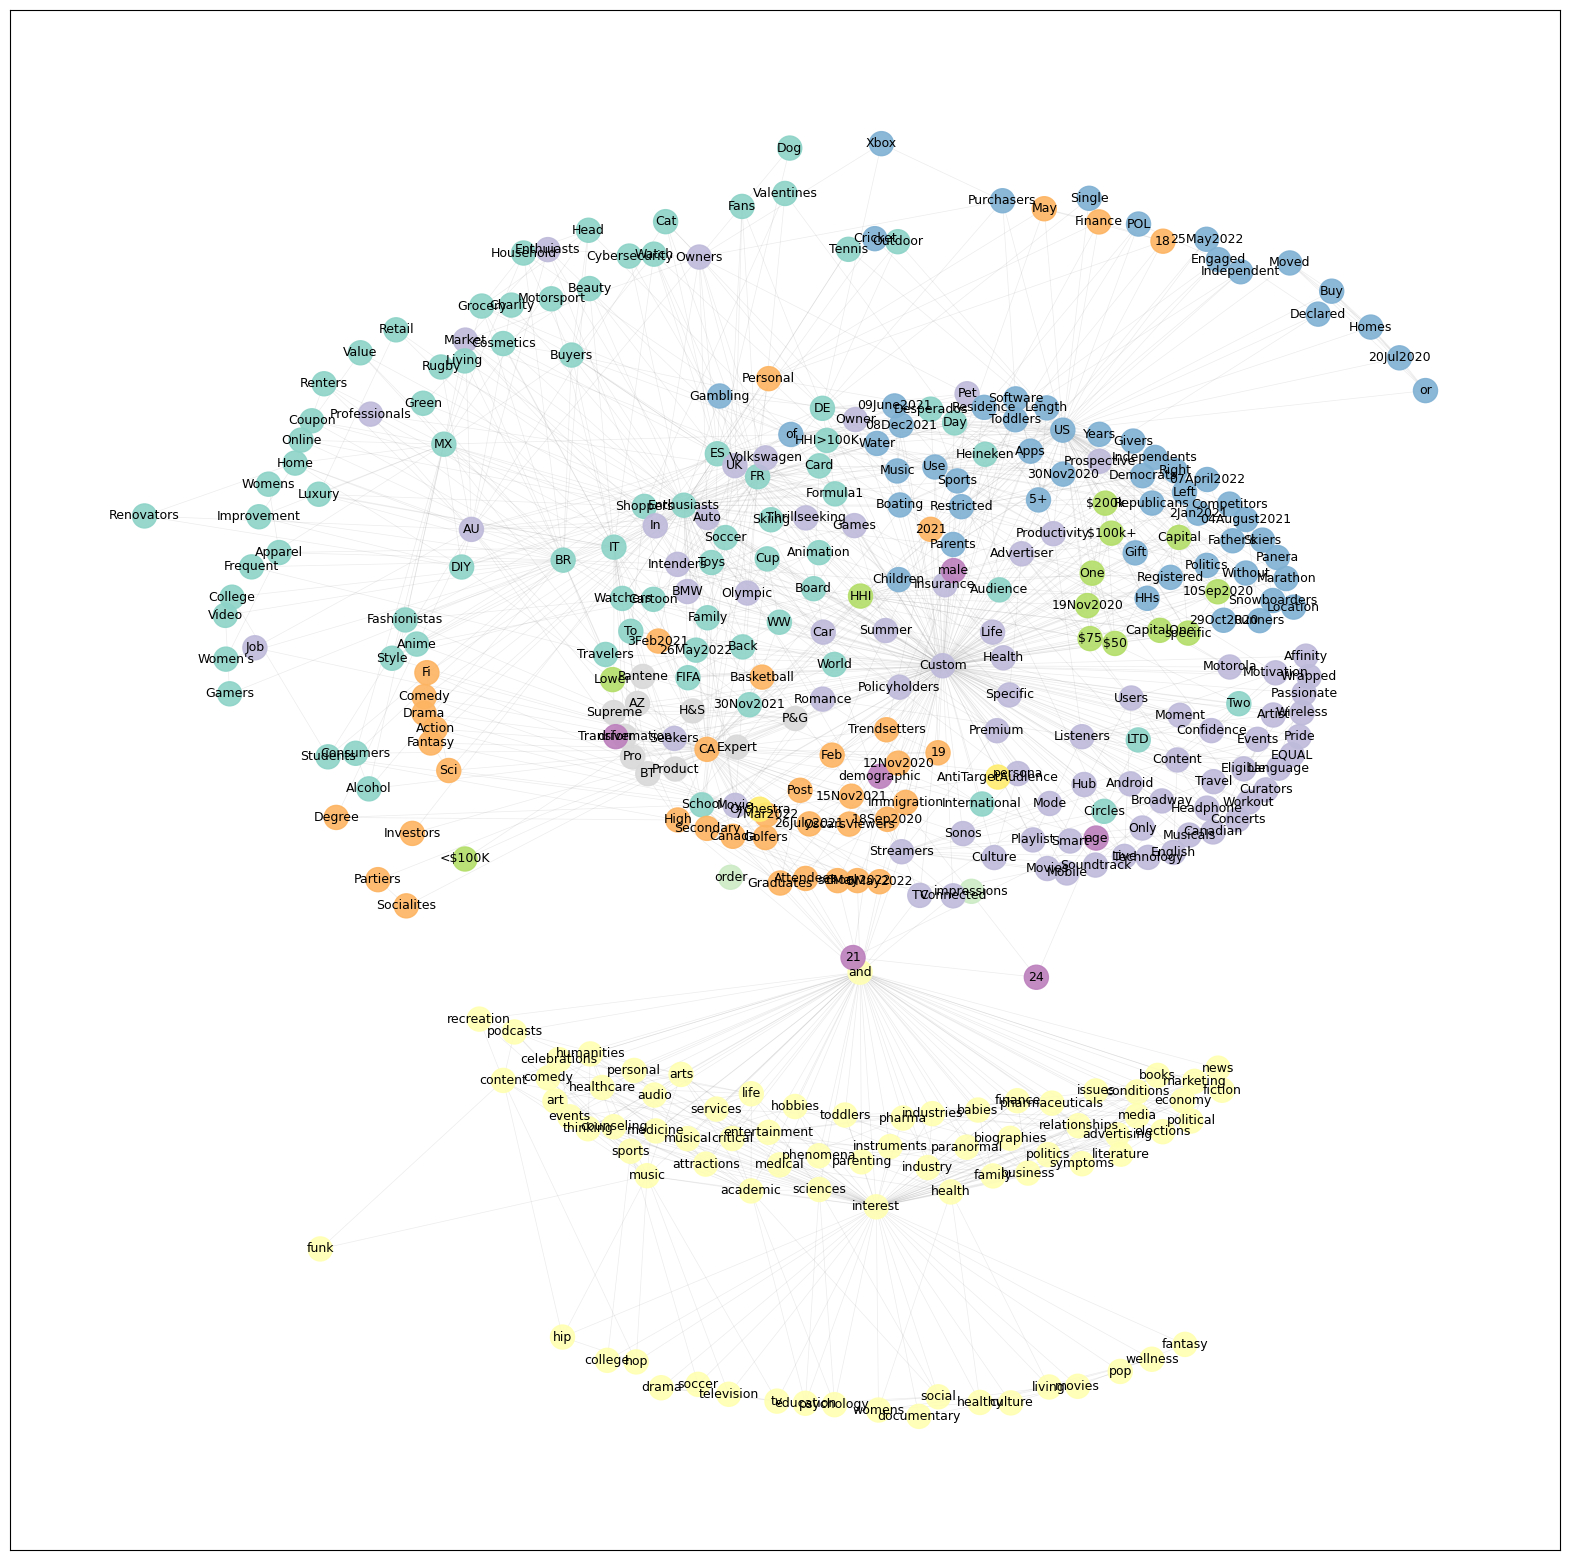

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community

threshold = 1
plt.figure(figsize=(20, 20))

G = nx.Graph()
for inf, freq in inferences_map.items():
    G.add_node(inf)

for inf_1 in unique_inf:
    for inf_2 in unique_inf:
        if inf_1 != inf_2 and co_occurance_boolean_mat.at[inf_1, inf_2] == 1:
            G.add_edge(inf_1, inf_2)

raw_sizes = list(inferences_map.values())
# sizes i= np.interp(raw_sizes, (min(raw_sizes), max(raw_sizes)), (100, 2500))

communities = community.greedy_modularity_communities(G)
node_community = {}
for i, comm in enumerate(communities):
    for node in comm:
        node_community[node] = i
colors = [node_community[n] for n in G.nodes()]

pos_init = nx.spring_layout(G, k=5, iterations=500)
pos = nx.kamada_kawai_layout(G, pos=pos_init, scale=4)

pos = {n: (x * 15, y * 5) for n, (x, y) in pos.items()}
labels = {k: k for k, v in inferences_map.items() if v >= threshold}

nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=plt.cm.Set3, alpha=0.9)
nx.draw_networkx_edges(G, pos, alpha=0.15, width=0.5, edge_color="gray")
nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, font_color="black")

plt.show()